HHU Deep Learning, WS2023/24, 08.12.2022

Lecture: Prof. Dr. Markus Kollmann

Exercises: Nikolas Adaloglou, Felix Michels

# Assignment 9 - Transfer Learning in Image Classification

---

Submit the solved notebook (not a zip) with your full name plus assignment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise, you will receive 1 point for this assignment, regardless of the quality of your solution.

## <center> DUE FRIDAY 15.12.2023 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/zDoBcOZiMPNar50](https://uni-duesseldorf.sciebo.de/s/zDoBcOZiMPNar50)

---

We will use `medmnist`, a python library that contains multiple medical imaging datasets for experimentation. You can install it locally via `pip install medmnist` or in google colab with `!pip install medmnist`

### The story

We found some pretrained resnet models on large-scale natural image data and we want to see if the learned weights are usefull for our medical image classification.

- Task 1 and 2: To this end, we will first evaluate the [K-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) (KNN) accuracy, using features from a pretrained resnet. We will compare the representations of resnet18 and resnet50
- Task 3: Next, we will use the features as training data, instead of the images, and train an MLP on top.
- Task 4: We will try to avoid overfitting by applying regularization techniques.
- Task 5: Finally, we will train the whole network (resnet50), starting from pretrained imagenet weights.

Our new goal is to reach a 95% val. accuracy on pathmnist.

In [1]:
!pip install medmnist
!wget -c https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/utils.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 24.9 MB/s eta 0:00:0000:0100:01
  Using cached fire-0.5.0.tar.gz (88 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 44.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116931 sha256=2a444196717db8a414c79d16f26157c5083d34866721936bc0b94c25120abc0d
  Stored in directory: /home/felix/.cache/pip/wheels/c4/eb/6a/1c6d2ad660043768e998bdf9c6a28db2f1b7db3a5825d51e87
Successfully built fire
--2023-12-07 15:21:09--  https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/utils.py
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HHU-MMBS/Deep-Learning-Exercise-Extras/m

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import medmnist
import torch
import matplotlib.pyplot as plt

from medmnist import INFO
from torchvision import transforms as T
from tqdm import tqdm

# Warning: local import - utils.py must be in the same folder as this notebook
from utils import *

# Specify dataset
data_flag = 'pathmnist'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
download = True
batch_size = 256
info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
print("n_classes", n_classes, info)
DataClass = getattr(medmnist, info['python_class'])

os.makedirs("./figs/", exist_ok=True)

n_classes 9 {'python_class': 'PathMNIST', 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.', 'url': 'https://zenodo.org/record/6496656/files/pathmnist.npz?download=1', 'MD5': 'a8b06965200029087d5bd730944a56c1', 'task': 'multi-class', 'label': {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorecta

Using downloaded and verified file: /home/felix/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/felix/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/felix/.medmnist/pathmnist.npz


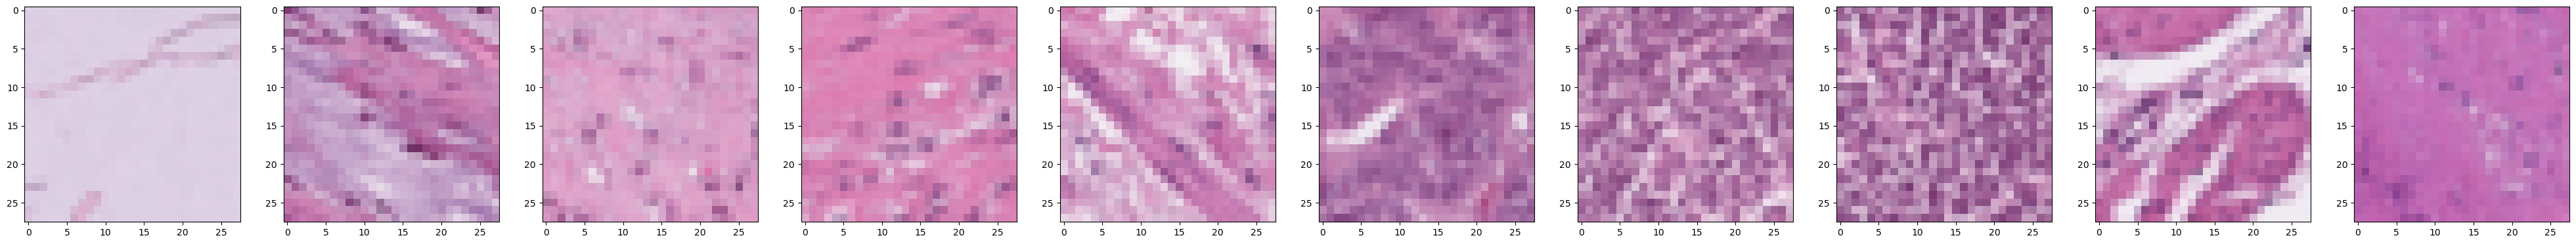

In [3]:
# Moves the range [0,1] to [-1,1]
mean = torch.tensor([0.5], dtype=torch.float32)
std = torch.tensor([0.5], dtype=torch.float32)

plain_transform = T.Compose([T.ToTensor(), T.Normalize(list(mean), list(std))])

# load the data
train_ds_plain = DataClass(split='train', transform=plain_transform, download=download)
val_ds = DataClass(split='val', transform=plain_transform, download=download)
test_ds = DataClass(split='test', transform=plain_transform, download=download)

train_loader_plain1 = data.DataLoader(dataset=train_ds_plain, batch_size=batch_size, shuffle=True, drop_last=True)

img1, lab = next(iter(train_loader_plain1))

# show the images
plt.figure(figsize = (50,20))
for i in range(10):
    imshow(train_ds_plain[i][0], i, mean, std)


# Task 1

Implement the logic of using a pretrained model to produce embeddings and apply KNN on top.
More precisly, given a pretrained model and a train and test loader, it computes the embeddings (on the gpu) and then uses the class `sklearn.neighbors.KNeighborsClassifier` to create a classifier. The classifier is created from the train embeddings and computes the train and test accuracy for both data splits.

### Optional - encapsulate the logic in a class
You can encapsulate the aforementioned logic by filling up the methods in the class below.
Minimal documentation is provided for each class method.
The method `execute` illustrates how the class methods should be used.

```python
class KnnConvnet():
    def __init__(self, model, device='cpu', distance='cosine'):
        super(KnnConvnet, self).__init__()
    def get_features(self, mode='train'):
    def set_features(self, embeds, labels, mode='train'):
    def extract_features(self, loader):
    def fit(self, features, labels, k):
    def accuracy(self, features, labels):
    
    @torch.no_grad()
    def execute(self, train_loader, test_loader=None, k=1):
        if self.embeds_train is None:
            embeds_train, lab_train = self.extract_features(train_loader)
            self.set_features(embeds_train, lab_train, mode='train')
        
        self.fit(self.embeds_train, self.lab_train, k)
        train_acc = self.accuracy(self.embeds_train, self.lab_train)

        if test_loader is not None:
            if self.embeds_test is None:
                embeds_test, lab_test = self.extract_features(test_loader)
                self.set_features(embeds_test, lab_test, mode='test')
            
            test_acc = self.accuracy(self.embeds_test, self.lab_test)
            return train_acc, test_acc
        
        return train_acc
```


#### Tips

- Feature extraction is much much faster on the GPU
- Use the cosine similarity as a distance metric


In [4]:
import numpy as np
import torch
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from torch import nn

class KnnConvnet():
    def __init__(self, model, device='cpu', distance='cosine'):
        self.device = device
        self.model = model.to(device)
        self.model.eval()
        self.embeds_train = None
        self.lab_train = None
        self.lab_test = None
        self.embeds_test = None
        self.distance = distance

    def get_features(self, mode='train'):
        """Returns the embeddings of the train or test set.
        Args:
            mode (str, optional): "train" or "test". Defaults to 'train'.
        """
        assert self.embeds_train is not None, 'Training embedding are not computed yet.'
        assert self.embeds_test is not None, 'Test embedding are not computed yet.'
        ### START CODE HERE ### (approx. 4 lines)
        if mode=='train':
            return self.embeds_train, self.lab_train
        else:
            return self.embeds_test, self.lab_test
        ### END CODE HERE ###

    def set_features(self, embeds, labels, mode='train'):
        """Sets the train or test embeddings and their labels."""
        ### START CODE HERE ### (approx. 6 lines)
        if mode=='train':
            self.embeds_train = embeds
            self.lab_train = labels
        else:
            self.embeds_test = embeds
            self.lab_test = labels
        ### END CODE HERE ###

    @torch.no_grad()
    def extract_features(self, loader):
        """Infers features from the provided image loader.
        Args:
            loader: train or test loader
        Returns: 3 tensors of all: features, labels
        """
        features = []
        label_lst = []
        ### START CODE HERE ### (approx. 4 lines)
        for input_tensor, label in loader:
            h = self.model(input_tensor.to(self.device))
            features.append(h)
            label_lst.append(label)
        ### END CODE HERE ###
        h_total = torch.cat(features)
        label_total = torch.cat(label_lst)
        return h_total, label_total

    @torch.no_grad()
    def fit(self, features, labels, k):
        """Fits the provided features to create a KNN classifer (i.e. self.cls object).
        Args:
            features: [... , dataset_size, feat_dim]
            labels: [... , dataset_size]
            k: number of nearest neighbours for majority voting
        """
        ### START CODE HERE ### (approx. 2 lines)
        features_np, labels_np = self.fix_dims(features, labels)
        self.cls = KNeighborsClassifier(k, metric=self.distance).fit(features_np, labels_np)
        ### END CODE HERE ###

    ### START HELPER ###
    def fix_dims(self, features, labels):
        """Reshapes the features and labels to have a shapes of
        [dataset_size, feat_dim], [dataset_size] respectivly
        """
        features = features.view(-1, features.shape[-1]).cpu().numpy()
        labels = labels.view(-1).cpu().numpy()
        return features, labels
    ### END HELPER ###

    def accuracy(self, features, labels):
        """Uses the features to compute the accuracy of the classifier (i.e. self.cls object)."""
        ### START CODE HERE ### (approx. 2 lines)
        features_np, labels_np = self.fix_dims(features, labels)
        acc = 100 * np.mean(self.cls.predict(features_np) == labels_np)
        ### END CODE HERE ###
        return acc

    @torch.no_grad()
    def execute(self, train_loader, test_loader=None, k=10):
        if self.embeds_train is None:
            embeds_train, lab_train = self.extract_features(train_loader)
            self.set_features(embeds_train, lab_train, mode='train')

        self.fit(self.embeds_train, self.lab_train, k)
        train_acc = self.accuracy(self.embeds_train, self.lab_train)

        if test_loader is not None:
            if self.embeds_test is None:
                embeds_test, lab_test = self.extract_features(test_loader)
                self.set_features(embeds_test, lab_test, mode='test')

            test_acc = self.accuracy(self.embeds_test, self.lab_test)
            return train_acc, test_acc

        return train_acc

def test_knn():
    d1 = torch.utils.data.Subset(train_ds_plain, list(range(300)))
    d2 = torch.utils.data.Subset(val_ds, list(range(100)))
    train_loader = data.DataLoader(dataset=d1, batch_size=32, shuffle=False, drop_last=False)
    test_loader = data.DataLoader(dataset=d2, batch_size=32, shuffle=False, drop_last=False)
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    knn_cls = KnnConvnet(model, device=device)
    for k in 1, 5:
        train_acc, test_acc = knn_cls.execute(train_loader, test_loader, k=k)
        print(f"train acc: {train_acc:.2f}%, test acc: {test_acc:.2f}%")

test_knn()

train acc: 100.00%, test acc: 48.00%
train acc: 74.67%, test acc: 56.00%


# Expected results

```
train acc: 100.00%, test acc: 48.00%
train acc: 74.67%, test acc: 56.00%
```


# Task 2: Use the KNN classifier on pretrained features of resnet50

Now we will use the KNN class together with two models: resnet50 and resnet18. These are out-of-the-box models, available in the `torchvision` package.  

- Load the resnet18 and resnet50 models from `torchvision`, pretrained on the imagenet dataset.
- Remove the last layer (use print(model) to see what it's called).
- Compute the image embeddings for all training and test data, using the `extract_features` function. These now serve as our new, transformed data. We will use the validation dataloader as test data.
- When computing the training accuracy, use a random subset of 10000 elements of the training data (otherwise it can be quite slow)
- Find the best choice of K in KNN (hyperparameter search). Try at least 4 different values of K for both models.
- Plot the results in a scatter plot for both resnet18 and resnet50.
- **Important: save the image embeddings** from resnet50 for the next task (i.e. with `torch.save`).

PS: Use the non-augmented train and validation dataloaders.

You are expected to observe at least 72% val accuracy with resnet50.

Hint: those working with google colab you can download files with:

```python
from google.colab import files
import pandas as pd
# saves file to local google colab enviroment
result.to_csv('example_file.csv')
# downloads it to your computer
files.download('example_file.csv')
```
It works with any type of file.

In [5]:
def get_model(modelname="resnet18", pretrained=True):
    ### START CODE HERE ### (approx. 2 lines)
    model = getattr(torchvision.models, modelname)(pretrained=pretrained)
    model.fc = nn.Identity()
    ### END CODE HERE ###
    return model

def run_knn_hp_tuning(model, train_loader, test_loader,
                        range_k = [5, 10, 15, 20], device='cpu', modelname='resnet'):
    train_acc_all = []
    val_acc_all = []
    knn_cls = KnnConvnet(model, device)

    print("Calc. train features")
    ### START CODE HERE ### (approx. 4 lines)
    train_embeds, labels = knn_cls.extract_features(train_loader)
    knn_cls.set_features(train_embeds, labels, mode='train')
    torch.save(train_embeds, f"./{modelname}_embeds_train.pt")
    torch.save(labels, f"./{modelname}_labels_train.pt")
    sub_idx = np.random.choice(len(train_embeds), 10000)
    train_embeds_sub = train_embeds[sub_idx]
    labels_sub = labels[sub_idx]
    ### END CODE HERE ###

    print("Calc. test features")
    ### START CODE HERE ### (approx. 4 lines)
    test_embeds, test_labels = knn_cls.extract_features(test_loader)
    knn_cls.set_features(test_embeds, test_labels, mode='train')
    torch.save(test_embeds, f"./{modelname}_embeds_test.pt")
    torch.save(test_labels, f"./{modelname}_labels_test.pt")
    ### END CODE HERE ###

    for k in range_k:
        ### START CODE HERE ### (approx. 3 lines)
        knn_cls.fit(train_embeds, labels, k)
        train_acc_all.append(knn_cls.accuracy(train_embeds_sub, labels_sub))
        val_acc_all.append(knn_cls.accuracy(test_embeds, test_labels))
        ### END CODE HERE ###
    return train_acc_all, val_acc_all

train_loader_plain2 = data.DataLoader(dataset=train_ds_plain, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(dataset=val_ds, batch_size=1024, shuffle=False, drop_last=False)

backbone_r18 = get_model("resnet18")
backbone_r50 = get_model("resnet50")

range_k = [5, 10, 15, 20]
train_acc_r18, val_acc_r18 = run_knn_hp_tuning(backbone_r18, train_loader_plain2,
    val_loader, range_k, device, modelname="resnet18")

train_acc_r50, val_acc_r50 = run_knn_hp_tuning(backbone_r50, train_loader_plain2,
    val_loader, range_k, device, modelname="resnet50")

/home/felix/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/felix/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/felix/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT

Calc. train features
Calc. test features
Calc. train features
Calc. test features


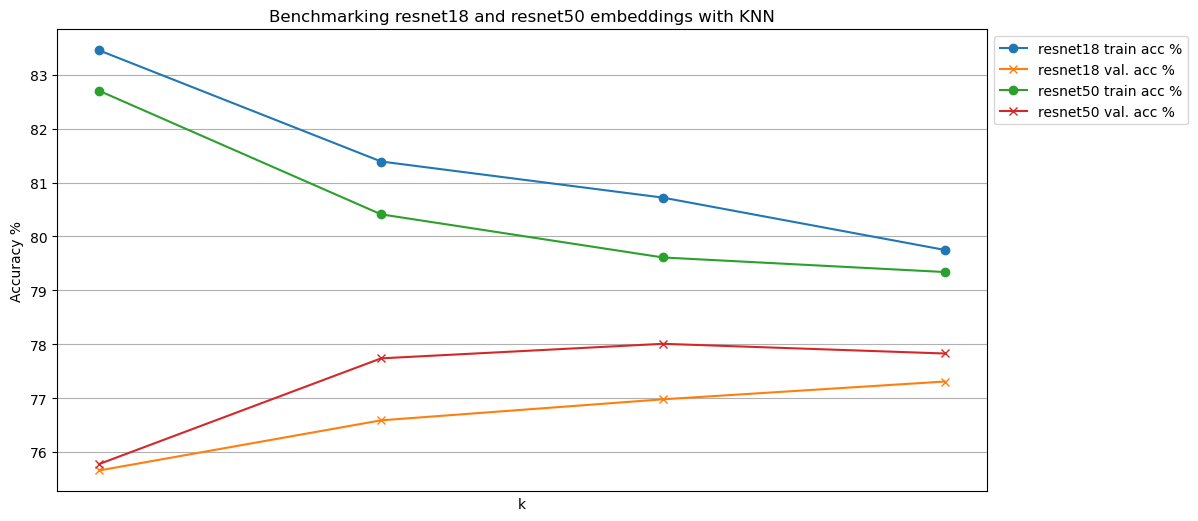

In [6]:
import matplotlib.pyplot as plt

def plot_knn_accs(range_k, train_acc_all, val_acc_all,  modelname='resnet18'):
    plt.plot(range_k, train_acc_all, marker='o', label=f'{modelname} train acc %')
    plt.plot(range_k , val_acc_all, marker='x', label=f"{modelname} val. acc %")

plt.figure(figsize=(12, 6))
plot_knn_accs(range_k, train_acc_r18, val_acc_r18,  modelname='resnet18')
plot_knn_accs(range_k, train_acc_r50, val_acc_r50,  modelname='resnet50')
plt.legend( bbox_to_anchor=(1,1), loc="upper left")
plt.grid()
plt.xticks([]) # hides x axis
plt.xlabel("k")
plt.ylabel(f"Accuracy %")
plt.title("Benchmarking resnet18 and resnet50 embeddings with KNN")
plt.savefig("./figs/knn_accs_resnets.png", dpi=500, bbox_inches='tight')
plt.show()

### Expected result

![im1](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/figs/knn_accs_resnets.png)

# Task 3: Train an MLP on the extracted image features from resnet50

- Create new datasets and dataloaders that return a pair of (features, labels) from resnet50 instead of the image.

Since we have precomputed the features, you can use `torch.load` here to load the features and labels and `torch.utils.data.TensorDataset` to make a dataset.

- Train a 2-layer MLP with a ReLU activation on the extracted features from the pretrained resnet50 as input data.
- Train for at least 100 epochs with Adam.
- Expected val accuracy is 84%

Hint: For small models, just nn.Sequential produces a fully functioning model. You don't need to define an extra class here.

Feature datasets have been created
Init Accuracy of the model: Train:12.784 	 Val:12.834867


Ep 99/100: Accuracy : Train:96.79 	 Val:81.85 || Loss: Train 0.122 	 Val 0.672: 100%|████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


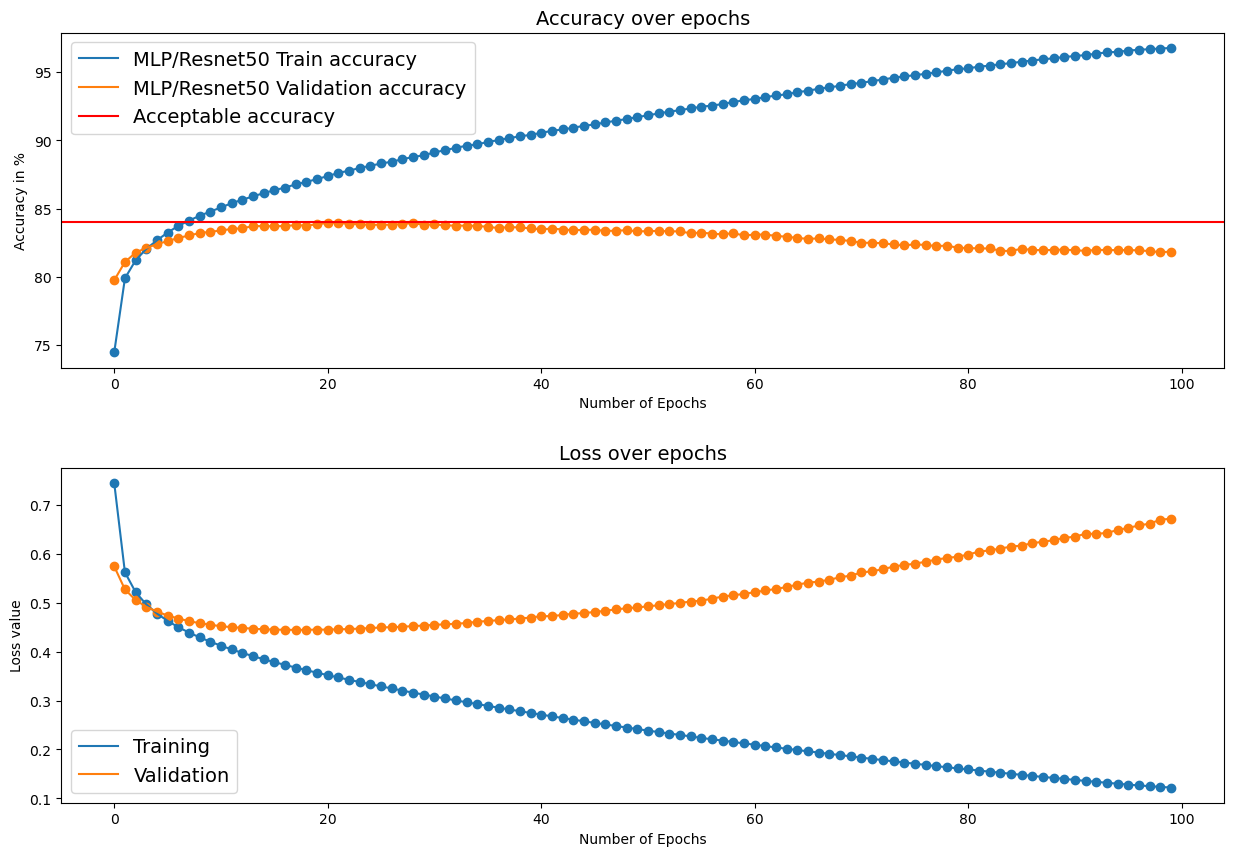

Best val. acc 83.9564208984375


In [7]:
# load embeds from hard disk
### START CODE HERE ### (approx. 2 lines)
x_train, y_train = torch.load("resnet50_embeds_train.pt"), torch.load("resnet50_labels_train.pt")
x_val, y_val = torch.load("resnet50_embeds_test.pt"), torch.load("resnet50_labels_test.pt")
### END CODE HERE ###

# create dataset
### START CODE HERE ### (approx. 2 lines)
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
### END CODE HERE ###
print("Feature datasets have been created")

# create dataloaders
### START CODE HERE ### (approx. 2 lines)
train_loader_features = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader_features = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
### END CODE HERE ###

# create model
### START CODE HERE ### (approx. 1 lines)
model = nn.Sequential(nn.Linear(2048, 128, 9), nn.ReLU(inplace=True), nn.Linear(128, n_classes))
### END CODE HERE ###

num_epochs = 100
# setup optimizer
### START CODE HERE ### (approx. 1 lines)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)
### END CODE HERE ###

dict_log = train(model, optimizer, num_epochs, train_loader_features, val_loader_features, device)

figsize = (15,10)
plt.figure(figsize=figsize)
plot_stats(dict_log, baseline=84, modelname="MLP/Resnet50")
plt.savefig(fname="./figs/mlp_resnet50_embeds.png", dpi=500, bbox_inches='tight')
plt.show()
print("Best val. acc", np.max(dict_log["val_acc_epoch"]))


### Expected result

![im2](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/figs/mlp_resnet50_embeds.png)

# Task 4: Regularization strategies
If you trained the model, you should be able to see the overfitting behaviour with a degradation in loss/accuracy towards the end of training.

What regularization strategies could you use to prevent the model from overfitting?

Experiment with at least 1 regularization strategy (apart from tuning the weight decay) and see if you can further increase the performance.

- Does regularization lead to performance improvement?
- How do the training dynamics change when training with stronger regularization strategies?

Init Accuracy of the model: Train:9.050 	 Val:8.826469


Ep 99/100: Accuracy : Train:83.15 	 Val:83.94 || Loss: Train 0.467 	 Val 0.439: 100%|████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


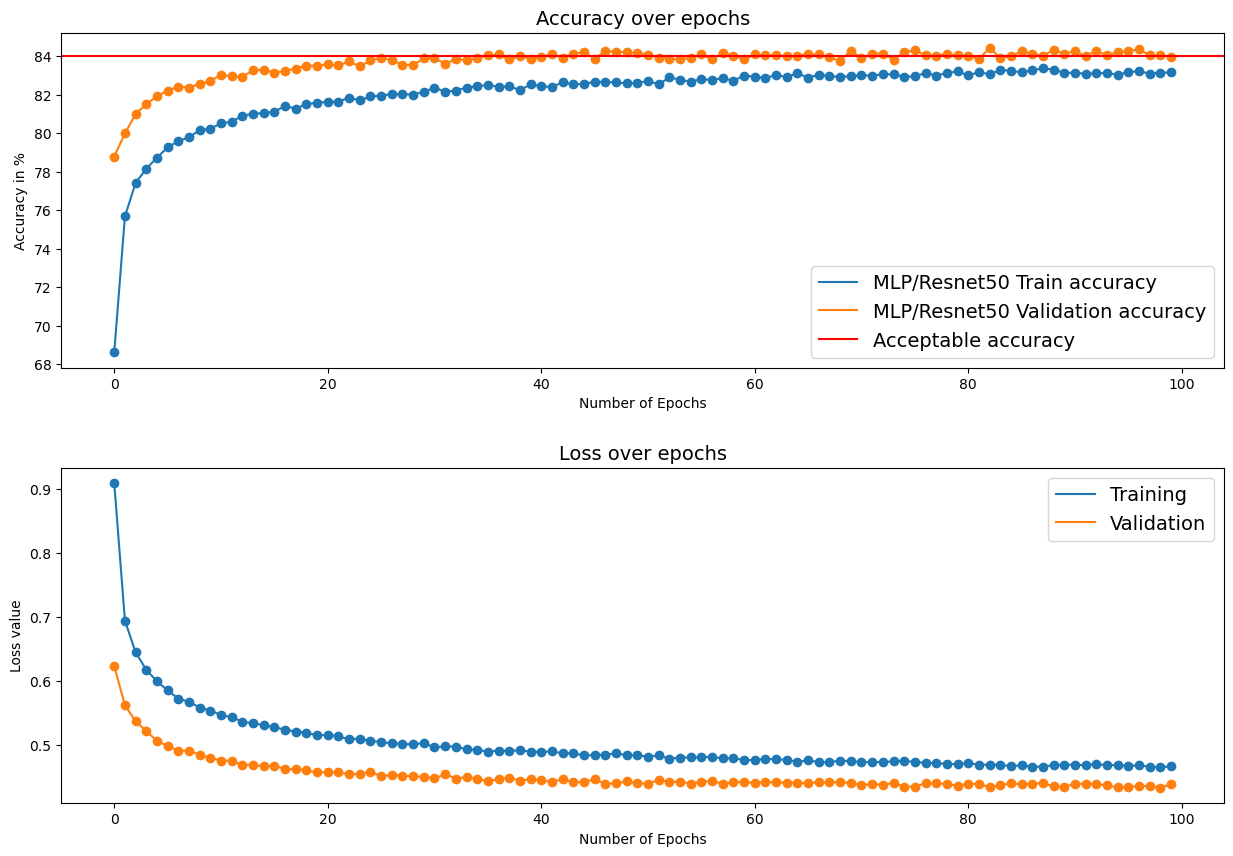

Best val. acc 84.4162368774414


In [8]:
### START CODE HERE ### (approx. 3 lines)
# Include dropout
model = nn.Sequential(nn.Linear(2048, 128), nn.ReLU(inplace=True), nn.Dropout(0.6), nn.Linear(128, n_classes))

num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.001)
### END CODE HERE ###

dict_log = train(model, optimizer, num_epochs, train_loader_features, val_loader_features, device)

figsize = (15,10)
plt.figure(figsize=figsize)
plot_stats(dict_log, baseline=84, modelname="MLP/Resnet50")
plt.savefig(fname="./figs/mlp_resnet50_embeds_regularization.png", dpi=500, bbox_inches='tight')
plt.show()
print("Best val. acc", np.max(dict_log["val_acc_epoch"]))

### Expected result

![im3](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/figs/mlp_resnet50_embeds_regularization.png)

# Task 5: Train the whole model (resnet50) on pathmnist starting from imagenet initialization.

Now we will re-train the whole model, using the pretrained weights as a starting point. Also, we add data-augmentation, see below for details.

Training data augmentations:
- Horizontal flip with 50% probability
- Random crop images to 50-100 % of the initial size
- Resize images to 28x28
- intensity jitter: 20% brightness and 20% contrast with 80% probability
- Mean/std norm with mean=0.5 and std=0.5 for all channels

At val/test time, only mean/std normalization will be applied.


Do the following:
- Load a pretrained resnet50. Remove the pretrained head (last layer). Add a two-layer MLP as the new last layer.
- Compute the number of trainable and non-trainable parameters.
- Train for 20 epochs.
- Plot training statistics
- Calculate test accuracy!


Compare the fine-tuned resnet50 on the pathmnist dataset with the previously trained MLP on the extracted features.

Expected val. acc is 95%

Using downloaded and verified file: /home/felix/.medmnist/pathmnist.npz
 Total params: 23.8 M , trainble params 23.8
Init Accuracy of the model: Train:9.080 	 Val:7.772436


Ep 19/20: Accuracy : Train:94.37 	 Val:92.25 || Loss: Train 0.164 	 Val 0.224: 100%|███████████████████████████| 20/20 [12:24<00:00, 37.22s/it]


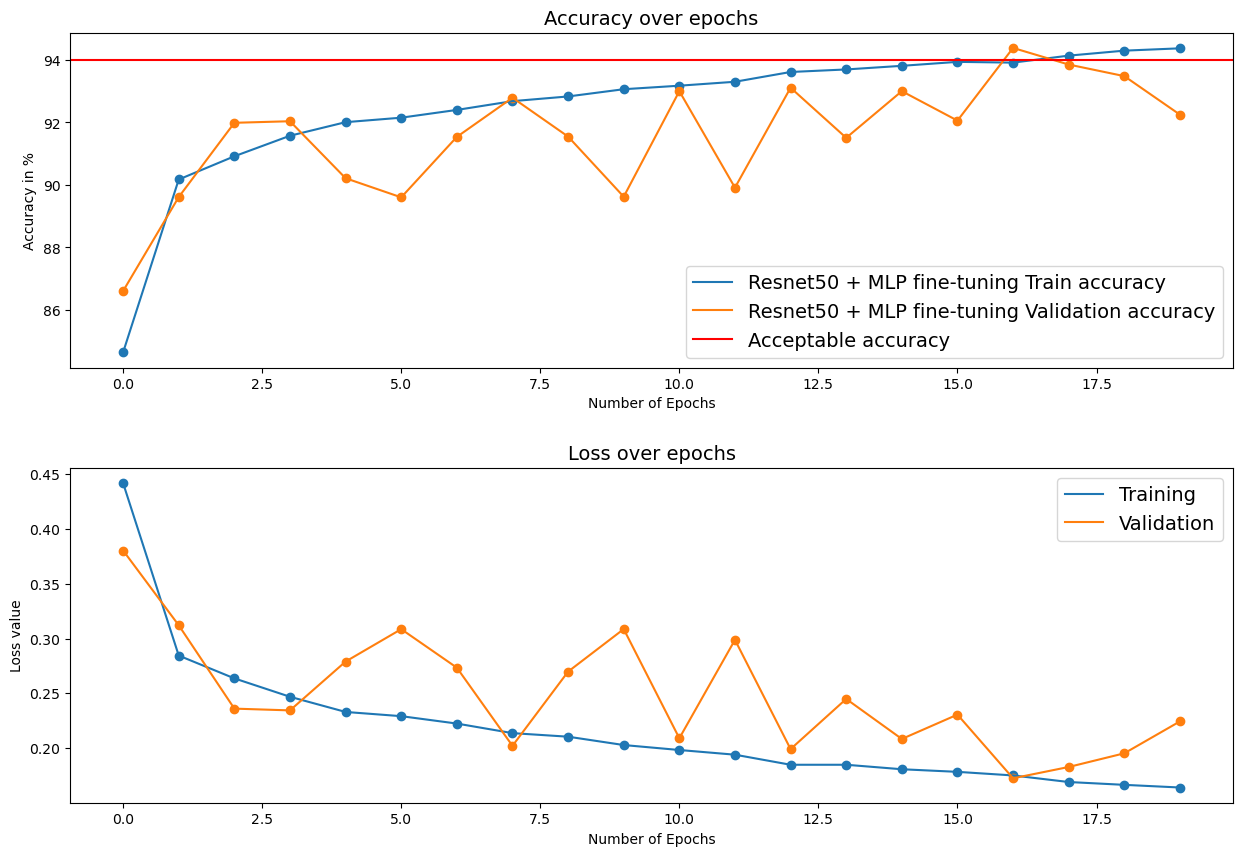

In [21]:
### START CODE HERE ### (approx. 9 lines)
# Specify transforms, maps from [0,1] to [-1,1]
mean = torch.tensor([0.5], dtype=torch.float32)
std = torch.tensor([0.5], dtype=torch.float32)

# needs to be defined
color_jitter = T.ColorJitter(brightness=0.2, contrast=0.2)
train_transform = T.Compose([
        T.ToTensor(),
        T.RandomHorizontalFlip(),
        T.RandomResizedCrop(size=28, scale=(0.5,1)),
        T.RandomApply([color_jitter], p=0.8),
        T.Normalize(list(mean), list(std))])
### END CODE HERE ###

# For val/time define a plain transform
plain_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(list(mean), list(std))])

# load the data
train_ds = DataClass(split='train', transform=train_transform, download=download)

train_loader = data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8, pin_memory=True, persistent_workers=True)
val_loader = data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True)

# create model
class ResnetMedNist(nn.Module):
    def __init__(self, hidden_mlp, n_classes):
        super(ResnetMedNist, self).__init__()
        ### START CODE HERE ### (approx. 3 lines)
        self.backbone = torchvision.models.resnet50(True)
        self.backbone.fc = nn.Identity()
        self.softmax = nn.Softmax()
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (approx. 1 lines)
        return self.mlp(self.backbone(x))
        ### END CODE HERE ###


# Initialize model and optimizer
num_epochs = 20
### START CODE HERE ### (approx. 2 lines)
model = ResnetMedNist(128, n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.001)
### END CODE HERE ###



# Number of parameters
### START CODE HERE ### (approx. 2 lines)
pytorch_total_params = sum(p.numel() for p in model.parameters()) / 1000000
pytorch_total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1000000
### END CODE HERE ###
print(f" Total params: {pytorch_total_params:.1f} M , trainble params {pytorch_total_params_trainable:.1f}")

dict_log = train(model, optimizer, num_epochs, train_loader, val_loader, device)

figsize = (15,10)
plt.figure(figsize=figsize)
plot_stats(dict_log, baseline=94, modelname="Resnet50 + MLP fine-tuning")
plt.savefig(fname="./figs/mlp_resnet50_finetune_embeds.png", dpi=500, bbox_inches='tight')
plt.show()

## Expected results
![im4](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/figs/mlp_resnet50_finetune_embeds.png)

# Task 6: Visualizing the nearest neighbors in the embeddings space.

- Load the embeddings (produced from resnet50) and their labels from the validation set.
- Take 1 image sample from each class.
- Calculate their top k=7 nearest neighbors (NN) using cosine similarity.
- Visualize the 7+1 images in one row. First one should be the reference image that we computed its NN.

PS: we use 7 so we can plot them in 1 row. Feel free to play around with more NN.

#### Questions
- What is the connections between the NN in the embedding space and the image labels?
- How many of the retrieved images in the embedding space share the same label?

Using downloaded and verified file: /home/felix/.medmnist/pathmnist.npz


/tmp/ipykernel_141642/3195137874.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(true_labels[j])


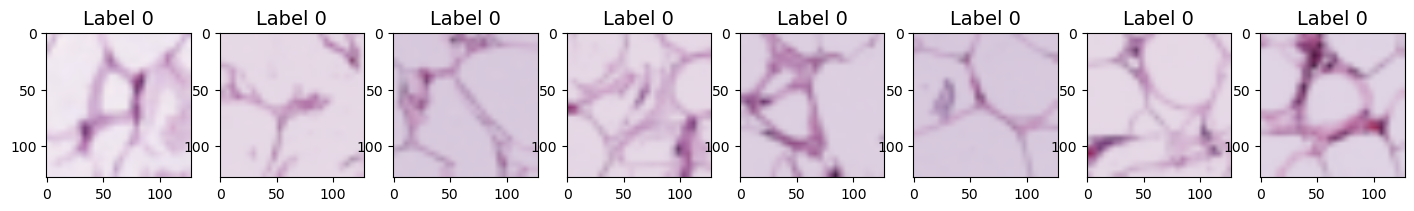

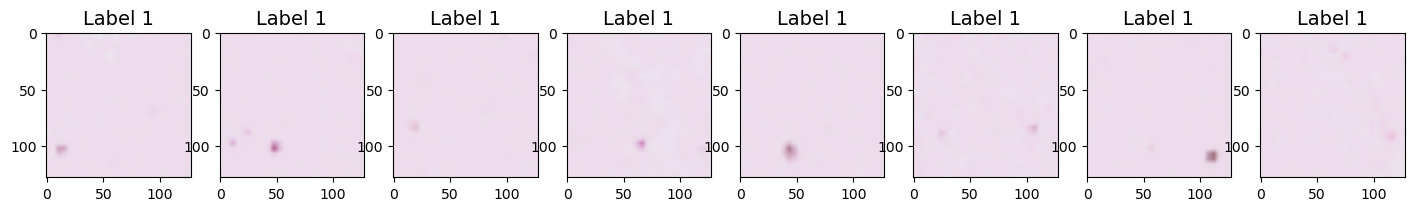

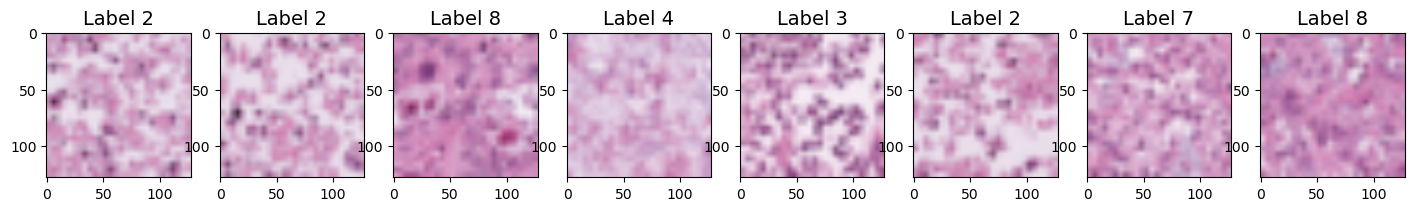

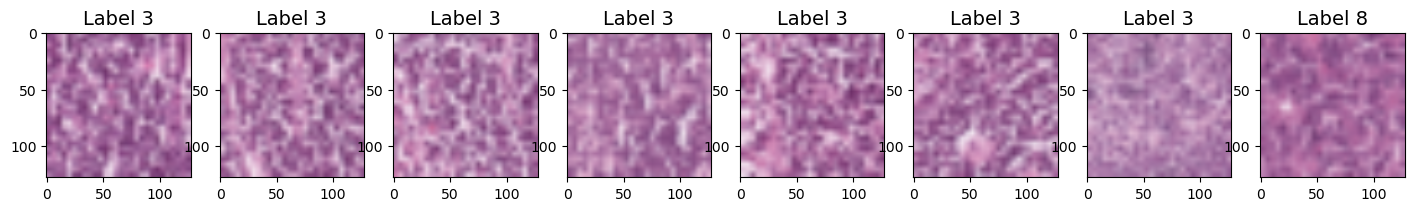

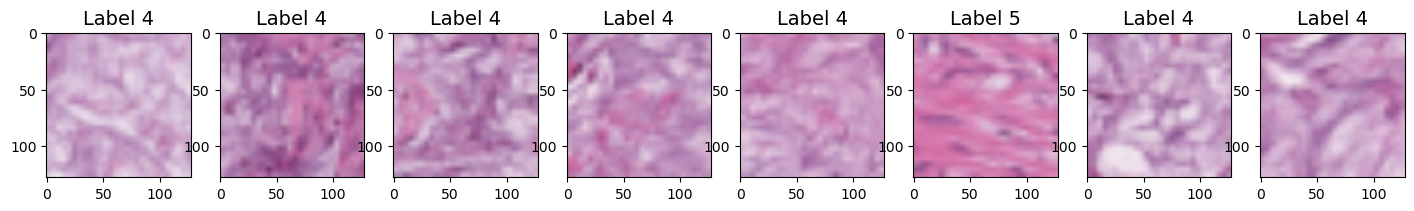

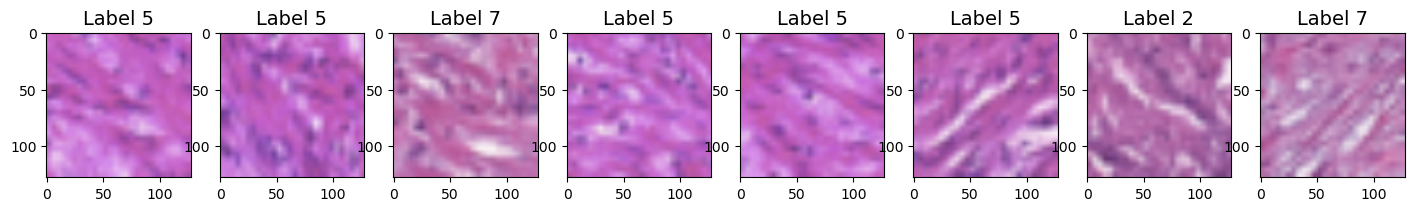

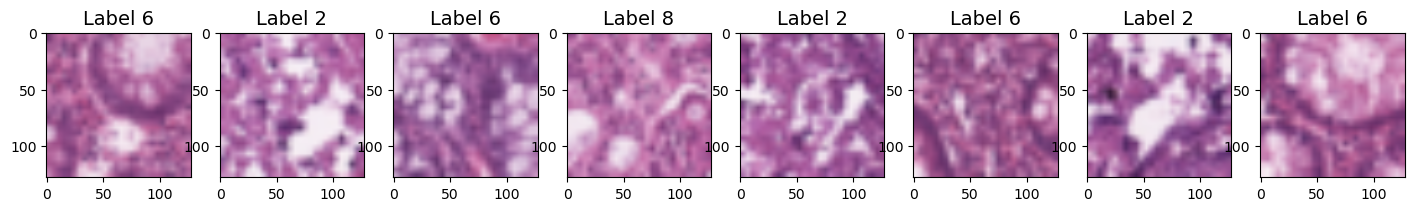

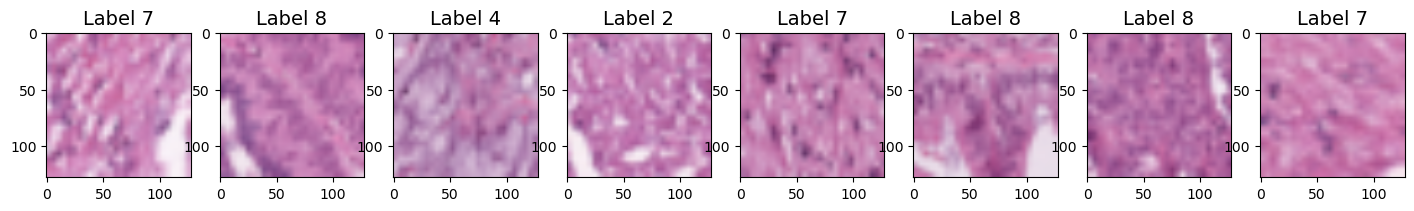

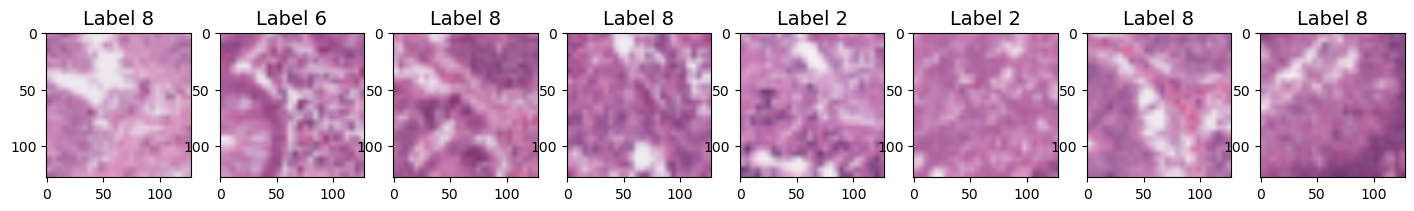

In [22]:
plain_transform = T.Compose([
        T.ToTensor(),
        T.Resize(128),
        T.Normalize(list(mean), list(std))])
val_ds = DataClass(split='val', transform=plain_transform, download=download)

### START CODE HERE ### (approx. 3 lines)
x_val , y_val = torch.load("resnet50_embeds_test.pt", map_location="cpu"), torch.load("resnet50_labels_test.pt", map_location="cpu")
y_val = y_val.squeeze()
x_val = x_val.to(device)
### END CODE HERE ###

# Normalize the embeddings, so that a normal vector product is the cosine similarity
### START CODE HERE ### (approx. 1 lines)
x_val /= x_val.norm(p=2, dim=-1, keepdim=True)
### END CODE HERE ###

ref_imgs = []  # Save one image per class
ref_ids = []  # Save the indices for these images
for j in range(n_classes):
    ### START CODE HERE ### (approx. 3 lines)
    ref_id = np.arange(len(y_val))[y_val==j][0]
    ref_imgs.append(x_val[ref_id])
    ref_ids.append(ref_id)
    ### END CODE HERE ###

ref_imgs = torch.stack(ref_imgs)

# For each image, compute the k nearest neighbours, according to cosine similarity
### START CODE HERE ### (approx. 3 lines)
k = 7
similarities = (ref_imgs @ x_val.T).cpu()
_, indices = similarities.topk(k=k+1, dim=-1, largest=True, sorted=True)
indices = indices[:,1:].cpu()
### END CODE HERE ###

# Visualize the reference image and its 7 nearest neighbors
for c, ref in enumerate(ref_ids):
    knns = indices[c]
    imgs_to_viz = [val_ds[ref][0]]
    true_labels = [val_ds[ref][1]]
    for i in knns:
        imgs_to_viz.append(val_ds[i][0])
        true_labels.append(val_ds[i][1])
    # show the images
    plt.figure(figsize = (22,14))
    for j in range(k+1):
        label = int(true_labels[j])
        imshow(imgs_to_viz[j], j, mean, std)
        plt.title(f"Label {label}", fontsize = 14)
    plt.savefig(f'./figs/knn_from_ref_label_id_{str(c).zfill(2)}',bbox_inches = "tight", dpi = 500)

### Expected results

![im6](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/figs/knn_from_ref_label_id_00.png)

![im7](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/figs/knn_from_ref_label_id_01.png)

![im8](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/figs/knn_from_ref_label_id_02.png)

![im9](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/figs/knn_from_ref_label_id_03.png)

![im10](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/figs/knn_from_ref_label_id_04.png)

![im11](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/figs/knn_from_ref_label_id_05.png)

![im12](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/figs/knn_from_ref_label_id_06.png)

![im13](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/figs/knn_from_ref_label_id_07.png)

![im14](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a09_transfer_learning/figs/knn_from_ref_label_id_08.png)
